# Extrinsic analysis

Input files of this notebook:

- file...

Output files of this notebook:

- file...

This notebook analyses the quality of OSM data on cycling infrastructure for a given area. 

The purpose of the evaluation is specifically to assess the fitness for use of OSM data for cycling research, particularly research projects based around network analysis, in which the topology of the geometries are of particular importance.

The notebook makes use of quality metrics previously used by a range of previous projects investigating OSM/VGI data quality, such as **XXXXXX (OBS! Add references here.)**

Running the notebook pressupposes that a reference data set is available for comparison. The reference data set should contain the same type of features (i.e. in the ideal world be identical to the data downloaded from OSM) for the comparison to make sense.

The analysis is based on comparing OSM data to the reference dataset and highlighting how and where they differ, both in terms of how *much* cycling infrastructure is mapped in the two datasets and concerning *how wthe infrastructure* is mapped (e.g. looking at differing network topology and structure).

While the analysis is based on a comparison, we make no no a priori assumptions about which dataset is better.

The identified differences between the two are thus not used to make any conclusion about which is better, but requires the user to interpret whether e.g. differing features are results of errors of omission or comission, and which dataset is more correct.

The goal is that the identified differences can be used by the user to both assess the quality of the OSM and the reference datasets, and to support the decision of which dataset should be used for analysis, if any.

For a correct interpretation of some of the metrics for spatial data quality, some familiarity with the area is necessary.

**Sections:**

TDAV possibly rename sections?

1. Load and process data
2. Data completeness
    - Network length
    - Network densities
        - Global network density
        - Local network density
        - Density of protected and unprotected infrastructure
3. Network structure
    - Alpha, beta and gamma
    - Simplification outcomes
    - Number of nodes and edges per infrastructure length
    - Local node/edge ratio
4. Network topology
    - Dangling nodes
    - Over and undershoots
5. Network component analysis
    - Number of CC
    - Component size distribution
    - Giant component
    - Ratio of edges to connected components
    - Grid cells with more than 1 component
    - Component connectivity
6. Save Results

_________________________

## 1. Load and process data

In [1]:
import geopandas as gpd
import pandas as pd
import osmnx as ox
import yaml
import matplotlib.pyplot as plt
import contextily as cx
import json
import pickle
from src import evaluation_functions as ef

### Load settings

In [2]:
with open(r'../config.yml') as file:

    parsed_yaml_file = yaml.load(file, Loader=yaml.FullLoader)

    study_area = parsed_yaml_file['study_area']
    study_area_poly_fp = parsed_yaml_file['study_area_poly']
    study_crs = parsed_yaml_file['study_crs']

    missing_tag_dict = parsed_yaml_file['missing_tag_analysis']

    incompatible_tags_dict = parsed_yaml_file['incompatible_tags_analysis']

    cycling_infrastructure_queries = parsed_yaml_file['cycling_infrastructure_queries']

    reference_geometries = parsed_yaml_file['reference_geometries']
    cycling_bidirectional = parsed_yaml_file['bidirectional']

    feature_matching = parsed_yaml_file['feature_matching']
    
print('Settings loaded!')

Settings loaded!


### Load OSM and reference graphs and grid

In [3]:
# Load simplified and non-simplified graphs
osm_graph = ox.load_graphml(f'../data/osm_{study_area}.graphml', edge_dtypes={'cycling_bidirectional': ox.io._convert_bool_string})
osm_simplified_graph = ox.load_graphml(f'../data/osm_{study_area}_simple.graphml', edge_dtypes={'cycling_bidirectional': ox.io._convert_bool_string, 'infrastructure_length':float})

# Convert to nodes and edges
osm_nodes, osm_edges = ox.graph_to_gdfs(osm_graph)
osm_simplified_nodes, osm_simplified_edges = ox.graph_to_gdfs(osm_simplified_graph)

# Load simplified and non-simplified graphs
ref_graph = ox.load_graphml(f'../data/ref_{study_area}.graphml')
ref_simplified_graph = ox.load_graphml(f'../data/ref_{study_area}_simple.graphml',edge_dtypes={'infrastructure_length':float})

# Convert to nodes and redges
ref_nodes, ref_edges = ox.graph_to_gdfs(ref_graph)
ref_simplified_nodes, ref_simplified_edges = ox.graph_to_gdfs(ref_simplified_graph)

# Fix converted boolean values
if cycling_bidirectional in ref_simplified_edges.columns:
    ref_simplified_edges.loc[ref_simplified_edges.cycling_bidirectional=='True','cycling_bidirectional'] = True
    ref_simplified_edges.loc[ref_simplified_edges.cycling_bidirectional=='False','cycling_bidirectional'] = False

# Load grid
grid = gpd.read_file(f'../data/grid_{study_area}.gpkg')
grid_ids = grid.grid_id.to_list()

print('Data loaded!')

# Joining grid cell id to network elements
osm_edges_s_j = gpd.overlay(osm_simplified_edges, grid, how ='intersection')
osm_edges_j = gpd.overlay(osm_edges, grid, how='intersection')

osm_nodes_s_j = gpd.overlay(osm_simplified_nodes, grid, how ='intersection')
osm_nodes_j = gpd.overlay(osm_nodes, grid, how='intersection')

# Count features in each grid cell
all_data_osm = [osm_edges_j,  osm_nodes_j, osm_edges_s_j, osm_nodes_s_j]
labels_osm = ['osm_edges','osm_nodes','osm_simplified_edges','osm_simplified_nodes']

for data, label in zip(all_data_osm, labels_osm):

    df = ef.count_features_in_grid(data,label)

    grid = grid.merge(df, on='grid_id', how='left')

ref_edges_s_j = gpd.overlay(ref_simplified_edges, grid, how ='intersection', keep_geom_type=True)
ref_edges_j = gpd.overlay(ref_edges, grid, how='intersection', keep_geom_type=True)

ref_nodes_s_j = gpd.overlay(ref_simplified_nodes, grid, how ='intersection', keep_geom_type=True)
ref_nodes_j = gpd.overlay(ref_nodes, grid, how='intersection', keep_geom_type=True)

# Count features in each grid cell
all_data_ref = [ref_edges_j,  ref_nodes_j, ref_edges_s_j, ref_nodes_s_j]
labels_ref = ['ref_edges','ref_nodes','ref_simplified_edges','ref_simplified_nodes']

for data, label in zip(all_data_ref, labels_ref):

    df = ef.count_features_in_grid(data,label)

    grid = grid.merge(df, on='grid_id', how='left')


# Recomputing infrastructure length for data joined to grid
osm_edges_s_j['length'] = osm_edges_s_j['geometry'].length
osm_edges_s_j['infrastructure_length'] = osm_edges_s_j.apply(lambda x: ef.measure_infrastructure_length(edge = x.geometry, 
                                                geometry_type=x.cycling_geometries, bidirectional=x.cycling_bidirectional, cycling_infrastructure=x.cycling_infrastructure), axis=1)


assert round(osm_simplified_edges.infrastructure_length.sum()/10000,0) == round(osm_edges_s_j.infrastructure_length.sum() / 10000,0) 


ref_edges_s_j['length'] = ref_edges_s_j['geometry'].length
if reference_geometries not in ['true_geometries','centerline'] and type(cycling_bidirectional) == str:
    ref_edges_s_j['infrastructure_length'] = ref_edges_s_j.apply(lambda x: ef.measure_infrastructure_length(edge = x.geometry, 
                                                        geometry_type=x.reference_geometries, bidirectional=x.cycling_bidirectional, cycling_infrastructure='yes'), axis=1)

elif reference_geometries in ['true_geometries','centerline'] and type(cycling_bidirectional) == bool:
    ref_edges_s_j['infrastructure_length'] = ref_edges_s_j.apply(lambda x: ef.measure_infrastructure_length(edge = x.geometry, 
                                                        geometry_type=reference_geometries, bidirectional=cycling_bidirectional, cycling_infrastructure='yes'), axis=1)

    
elif reference_geometries in ['true_geometries','centerline'] and type(cycling_bidirectional) == str:
    ref_edges_s_j['infrastructure_length'] = ref_edges_s_j.apply(lambda x: ef.measure_infrastructure_length(edge = x.geometry, 
                                                        geometry_type=reference_geometries, bidirectional=x.cycling_bidirectional, cycling_infrastructure='yes'), axis=1)

    
elif reference_geometries not in ['true_geometries','centerline'] and type(cycling_bidirectional) == bool:
    ref_edges_s_j['infrastructure_length'] = ref_edges_s_j.apply(lambda x: ef.measure_infrastructure_length(edge = x.geometry, 
                                                        geometry_type=x.reference_geometries, bidirectional=cycling_bidirectional, cycling_infrastructure='yes'), axis=1)
    
else:
    print(f'Invalid data types for the variables reference_geometetries and/or cycling_bidirectional!')


assert round(ref_simplified_edges.infrastructure_length.sum()/1000,1) == round(ref_edges_s_j.infrastructure_length.sum() / 1000,1)

assert len(osm_nodes) == len(osm_nodes.node_id.unique())
assert len(osm_edges) == len(osm_edges.edge_id.unique())
assert len(osm_simplified_edges) == len(osm_simplified_edges.edge_id.unique())
assert len(osm_simplified_nodes) == len(osm_simplified_nodes.node_id.unique())

assert 'infrastructure_length' in osm_simplified_edges.columns
assert 'length' in osm_edges.columns

assert len(ref_nodes) == len(ref_nodes.node_id.unique())
assert len(ref_edges) == len(ref_edges.edge_id.unique())
assert len(ref_simplified_edges) == len(ref_simplified_edges.edge_id.unique())
assert len(ref_simplified_nodes) == len(ref_simplified_nodes.node_id.unique())

assert 'infrastructure_length' in ref_simplified_edges.columns
assert 'length' in ref_edges.columns

print('Data processing completed!')

# Dictionaries for saving results
all_results = {}
results_ref = {}
results_osm = {}

Data loaded!
Data processing completed!


### Plot data

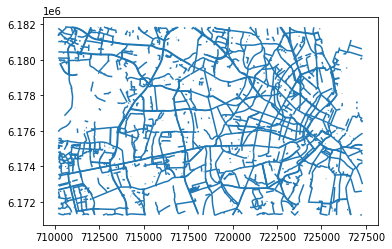

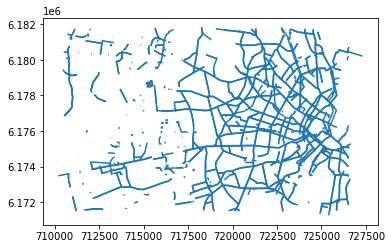

In [4]:
# TODO: Plot
osm_simplified_edges.plot()

# TODO: Plot
ref_simplified_edges.plot();

_________________

## 2. Network completeness

This section compares the two datasets in terms of completeness.

The goal is thus to identify if one dataset has more cycling infrastructure mapped than the other, and if so, if those differences are concentrated in some areas.

To account for differences in how cycling infrastructure have been mapped, the computation of network length and density is based on the infrastructure length, not the geometric length of the network edges.

### Why?

### How?

### What could it mean?

### Network length

In [5]:
ref_length = ref_simplified_edges.infrastructure_length.sum()

osm_length = osm_simplified_edges.infrastructure_length.sum()

diff = abs(osm_length - ref_length)

percent_diff = (osm_length - ref_length) / osm_length * 100

# TODO: Add plot visualising lenght difference

print(f'There is an {diff/1000:.2f} km length difference between the two datasets')

print(f'The difference between the length of the OSM and the reference data is {percent_diff:.2f}%')

all_results['ref_infra_length_m'] = ref_length
all_results['osm_infra_length_m'] = osm_length
all_results['length_difference_osm_ref'] = diff
all_results['pct_length_difference'] = percent_diff

There is an 441.11 km length difference between the two datasets
The difference between the length of the OSM and the reference data is 41.43%


**Comparing number of nodes and edges:**

*Is this interesting? Does not say that much in itself.* *Maybe remove*

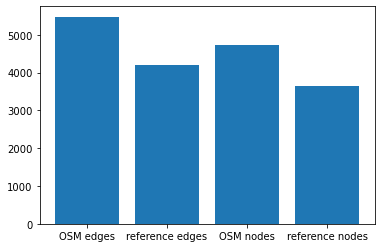

In [6]:
osm_nodes_count = len(osm_simplified_nodes)
osm_edges_count = len(osm_simplified_edges)

ref_nodes_count = len(ref_simplified_nodes)
ref_edges_count = len(ref_simplified_edges)

# TODO: format plot
values = [osm_edges_count, ref_edges_count, osm_nodes_count, ref_nodes_count]
labels = ['OSM edges','reference edges', 'OSM nodes', 'reference nodes']

plt.bar(range(len(values)), values, tick_label=labels);

results_osm['node_count'] = osm_nodes_count
results_osm['edge_count'] = osm_edges_count
results_ref['node_count'] = ref_nodes_count
results_ref['edge_count'] = ref_edges_count

### Network Densities

#### Why?

#### How?

#### What could it mean?

#### Global Network Density

In [7]:
# Entire study area
osm_edge_density, osm_node_density, osm_dangling_node_density = ef.compute_network_density((osm_simplified_edges, osm_simplified_nodes),grid.unary_union.area, return_dangling_nodes=True)


results_osm['edge_density_m_sqkm'] = osm_edge_density
results_osm['node_density_sqkm'] = osm_node_density
results_osm['dangling_node_density_sqkm'] = osm_dangling_node_density

print(f'For the entire study area, there are {osm_edge_density:.2f} meters of cycling infrastructure per square km in OSM')
print(f'For the entire study area, there are {osm_node_density:.2f} nodes in the cycling network per square km in OSM')
print(f'For the entire study area, there are {osm_dangling_node_density:.2f} dangling nodes in the cycling network per square km in OSM')

ref_edge_density, ref_node_density, ref_dangling_node_density = ef.compute_network_density((ref_simplified_edges, ref_simplified_nodes),grid.unary_union.area, return_dangling_nodes=True)


results_ref['edge_density_m_sqkm'] = ref_edge_density
results_ref['node_density_sqkm'] = ref_node_density
results_ref['dangling_node_density_sqkm'] = ref_dangling_node_density

print(f'For the entire study area, there are {ref_edge_density:.2f} meters of cycling infrastructure per square km in the reference data')
print(f'For the entire study area, there are {ref_node_density:.2f} nodes in the cycling network per square km in the reference data')
print(f'For the entire study area, there are {ref_dangling_node_density:.2f} dangling nodes in the cycling network per square km in the reference data')



For the entire study area, there are 5869.44 meters of cycling infrastructure per square km in OSM
For the entire study area, there are 26.05 nodes in the cycling network per square km in OSM
For the entire study area, there are 9.84 dangling nodes in the cycling network per square km in OSM
For the entire study area, there are 3437.55 meters of cycling infrastructure per square km in the reference data
For the entire study area, there are 20.15 nodes in the cycling network per square km in the reference data
For the entire study area, there are 4.81 dangling nodes in the cycling network per square km in the reference data


#### Local Network Density

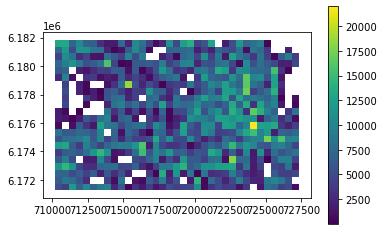

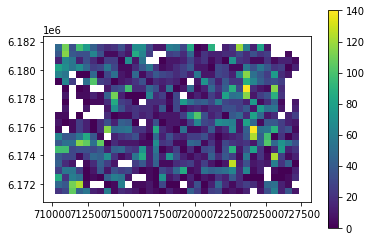

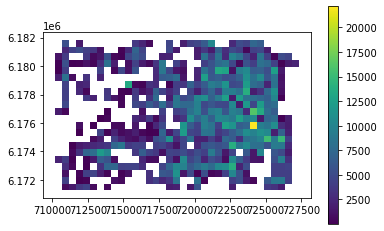

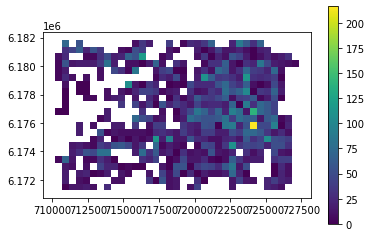

In [8]:
results_dict = {}
data = (osm_edges_s_j, osm_nodes_s_j)
[ef.run_grid_analysis(grid_id, data, results_dict, ef.compute_network_density, grid['geometry'].loc[grid.grid_id==0].area[0]) for grid_id in grid_ids];

results_df = pd.DataFrame.from_dict(results_dict, orient='index')
results_df.reset_index(inplace=True)
results_df.rename(columns={'index':'grid_id', 0:'osm_edge_density',1:'osm_node_density'}, inplace=True)

grid = grid.merge(results_df, on='grid_id', how='left')

# TODO: Format plotting
grid.plot(column='osm_edge_density', legend=True)
grid.plot(column='osm_node_density', legend=True)

results_dict = {}
data = (ref_edges_s_j, ref_nodes_s_j)

[ef.run_grid_analysis(grid_id, data, results_dict, ef.compute_network_density, grid['geometry'].loc[grid.grid_id==0].area[0]) for grid_id in grid_ids];

results_df = pd.DataFrame.from_dict(results_dict, orient='index')
results_df.reset_index(inplace=True)
results_df.rename(columns={'index':'grid_id', 0:'ref_edge_density',1:'ref_node_density'}, inplace=True)

grid = grid.merge(results_df, on='grid_id', how='left')

# TODO: Format plotting
grid.plot(column='ref_edge_density', legend=True);
grid.plot(column='ref_node_density', legend=True);


##### Local differences in network density

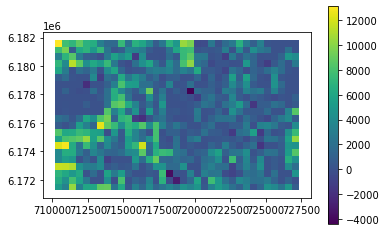

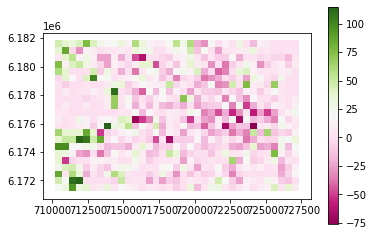

In [9]:
grid['edge_density_diff'] = grid.osm_edge_density.fillna(value=0) - grid.ref_edge_density.fillna(value=0)
grid['node_density_diff'] = grid.osm_node_density.fillna(value=0) - grid.ref_node_density.fillna(value=0)

# TODO: Format plotting OBS! If they go below zero, as with node diff here, this should be emphasized!
grid.plot(column='edge_density_diff', legend=True);
grid.plot(column='node_density_diff', legend=True, cmap='PiYG');

#### Differences in density between protected/unprotected cycling infrastructure

##### Global Network Density for Protected/Unprocected Infrastructure

In [10]:
osm_protected = osm_edges_s_j.loc[osm_edges_s_j.protected=='protected']
osm_unprotected = osm_edges_s_j.loc[osm_edges_s_j.protected=='unprotected']
osm_mixed = osm_edges_s_j.loc[osm_edges_s_j.protected=='mixed']

ref_protected = ref_edges_s_j.loc[ref_edges_s_j.protected=='protected']
ref_unprotected = ref_edges_s_j.loc[ref_edges_s_j.protected=='unprotected']
ref_mixed = ref_edges_s_j.loc[ref_edges_s_j.protected=='mixed']

osm_data = [osm_protected, osm_unprotected, osm_mixed]
ref_data = [ref_protected, ref_unprotected, ref_mixed]

labels = ['protected_density', 'unprotected_density','mixed_density']

for data, label in zip(osm_data, labels):
    if len(data) > 0:
        osm_edge_density_type, _ = ef.compute_network_density((data, osm_simplified_nodes),grid.unary_union.area, return_dangling_nodes=False)
        results_osm[label+'_m_sqkm'] = osm_edge_density_type

        print(f'Density for {label}: {osm_edge_density_type:.2f} in OSM data')

for data, label in zip(ref_data, labels):
    if len(data) > 0:
        ref_edge_density_type, _ = ef.compute_network_density((data, ref_simplified_nodes),grid.unary_union.area, return_dangling_nodes=False)
        results_ref[label+'_m_sqkm'] = ref_edge_density_type

        print(f'Density for {label}: {ref_edge_density_type:.2f} in reference data')


Density for protected_density: 5303.09 in OSM data
Density for unprotected_density: 514.78 in OSM data
Density for mixed_density: 51.40 in OSM data
Density for protected_density: 2996.63 in reference data
Density for unprotected_density: 440.92 in reference data


##### Local network density for protected/unprocected infrastructure

In [11]:
osm_labels = ['osm_protected_density', 'osm_unprotected_density','osm_mixed_density']
ref_labels = ['ref_protected_density', 'ref_unprotected_density','ref_mixed_density']

for data, label in zip(osm_data, osm_labels):
    if len(data) > 0:
        results_dict = {}
        data = (osm_edges_s_j.loc[data.index], osm_nodes_s_j)
        [ef.run_grid_analysis(grid_id, data, results_dict, ef.compute_network_density, grid['geometry'].loc[grid.grid_id==0].area[0]) for grid_id in grid_ids];

        results_df = pd.DataFrame.from_dict(results_dict, orient='index')
        results_df.reset_index(inplace=True)
        results_df.rename(columns={'index':'grid_id', 0:label}, inplace=True)
        results_df.drop(1,axis=1,inplace=True)

        grid = grid.merge(results_df, on='grid_id', how='left')

for data, label in zip(ref_data, ref_labels):
    if len(data) > 0:
        results_dict = {}
        data = (osm_edges_s_j.loc[data.index], osm_nodes_s_j)
        [ef.run_grid_analysis(grid_id, data, results_dict, ef.compute_network_density, grid['geometry'].loc[grid.grid_id==0].area[0]) for grid_id in grid_ids];

        results_df = pd.DataFrame.from_dict(results_dict, orient='index')
        results_df.reset_index(inplace=True)
        results_df.rename(columns={'index':'grid_id', 0:label}, inplace=True)
        results_df.drop(1,axis=1,inplace=True)

        grid = grid.merge(results_df, on='grid_id', how='left')


grid['protected_density_diff'] = grid.osm_protected_density.fillna(value=0) - grid.ref_protected_density.fillna(value=0)
grid['unprotected_density_diff'] = grid.osm_unprotected_density.fillna(value=0) - grid.ref_unprotected_density.fillna(value=0)

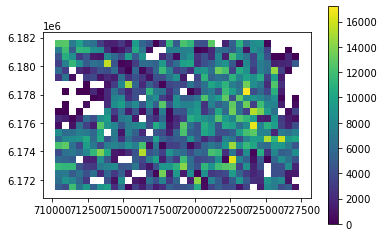

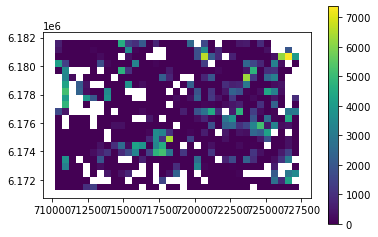

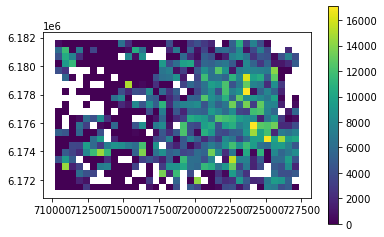

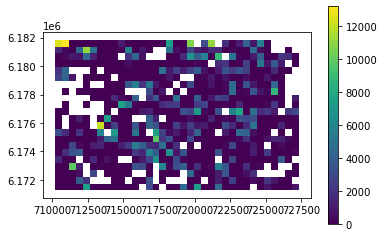

In [12]:
# TODO: format plotting
grid.plot(column='osm_protected_density', legend=True)
grid.plot(column='osm_unprotected_density', legend=True)

grid.plot(column='ref_protected_density', legend=True)
grid.plot(column='ref_unprotected_density', legend=True);

#### Differences in network density for respectively protected and unprotected infrastructure

Positive values indicate that the OSM density of the infrastructure type is higher than the reference density, negative values that the OSM density is lower.

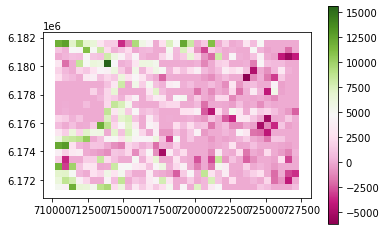

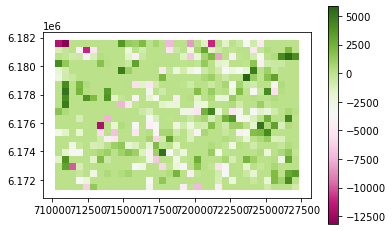

In [13]:
# TODO: Format plotting OBS! If they go below zero, as with node diff here, this should be emphasized!

grid.plot(column='protected_density_diff', legend=True, cmap='PiYG')
grid.plot(column='unprotected_density_diff', legend=True, cmap='PiYG');

___________________

## 3. Network structure

While the section above has tried to give the tools answer how much the two datasets differ in terms of how much infrastructure they describe, the section below will focus on qualitative differences in how the infrastructure is mapped.

### What?

### How?

### What could it mean?

### Alpha, beta and gamma

The network metrics alpha, beta and gamma descripe respectively describe:
- Alpha: "A measure of connectivity which evaluates the number of cycles in a graph in comparison with the maximum number of cycles. The higher the alpha index, the more a network is connected"
- Beta: "Measures the level of connectivity in a graph and is expressed by the relationship between the number of edges over the number of nodes." A higher beta value indicates a more complex network.
- Gamma: "A measure of connectivity that considers the relationship between the number of observed links and the number of possible links" ([Ducruet and Rodrigue, 2020](https://transportgeography.org/contents/methods/graph-theory-measures-indices/))

These metrics do not say much about the data quality itself, but if they are very similiar for the two networks, despite the network e.g. having very different lengths, this suggests that the data sets have been mapped in roughly the same way, but than one simply includes more features than the other. 

On the other hand, ff the networks are roughly the same size but the values from alpha, beta and gamma differ, this can be an indication that the structure and topology of the two datasets are fundamentally different.

In [ ]:
osm_alpha, osm_beta, osm_gamma = ef.compute_alpha_beta_gamma(osm_simplified_edges, osm_simplified_nodes)

print(f'Alpha for the simplified OSM network is: {osm_alpha:.2f}')
print(f'Beta for the simplified OSM network is: {osm_beta:.2f}')
print(f'Gamma for the simplified OSM network is: {osm_gamma:.2f}')

ref_alpha, ref_beta, ref_gamma = ef.compute_alpha_beta_gamma(ref_simplified_edges, ref_simplified_nodes)

print(f'Alpha for the simplified reference network is: {ref_alpha:.2f}')
print(f'Beta for the simplified reference network is: {ref_beta:.2f}')
print(f'Gamma for the simplified reference network is: {ref_gamma:.2f}')


results_osm['alpha'] = osm_alpha
results_osm['beta'] = osm_beta
results_osm['gamma'] = osm_gamma

results_ref['alpha'] = ref_alpha
results_ref['beta'] = ref_beta
results_ref['gamma'] = ref_gamma


### Outcome of network simplification

In [14]:
osm_edge_percent_diff = (len(osm_edges) - len(osm_simplified_edges)) / len(osm_edges)*100
osm_node_percent_diff = (len(osm_nodes) - len(osm_simplified_nodes)) / len(osm_nodes)*100
print(f'Simplifying the OSM network decreased the number of edges with {osm_edge_percent_diff:.1f}%')
print(f'Simplifying the OSM network decreased the number of nodes with {osm_node_percent_diff:.1f}%')

ref_edge_percent_diff = (len(ref_edges) - len(ref_simplified_edges)) / len(ref_edges)*100
ref_node_percent_diff = (len(ref_nodes) - len(ref_simplified_nodes)) / len(ref_nodes)*100
print(f'Simplifying the reference network decreased the number of edges with {ref_edge_percent_diff:.1f}%')
print(f'Simplifying the reference network decreased the number of nodes with {ref_node_percent_diff:.1f}%')


results_osm['simplified_edge_pct_diff'] = osm_edge_percent_diff
results_osm['simplified_node_pct_diff'] = osm_node_percent_diff

results_ref['simplified_edge_pct_diff'] = ref_edge_percent_diff
results_ref['simplified_node_pct_diff'] = ref_node_percent_diff

Simplifying the OSM network decreased the number of edges with 82.5%
Simplifying the OSM network decreased the number of nodes with 84.5%
Simplifying the reference network decreased the number of edges with 60.2%
Simplifying the reference network decreased the number of nodes with 63.5%


### Number of nodes and edges per infrastructure length

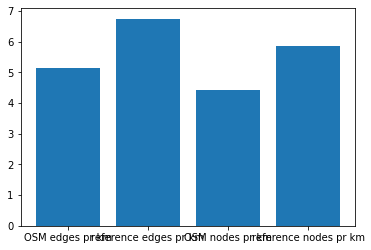

In [15]:
# TODO Should it be geometric length instead?

osm_nodes_count = len(osm_simplified_nodes)
osm_edges_count = len(osm_simplified_edges)

ref_nodes_count = len(ref_simplified_nodes)
ref_edges_count = len(ref_simplified_edges)

ref_total_length = ref_simplified_edges.infrastructure_length.sum() / 1000
osm_total_length = osm_simplified_edges.infrastructure_length.sum() / 1000

ref_edges_pr_km = ref_edges_count/ref_total_length
osm_edges_pr_km = osm_edges_count/osm_total_length

ref_nodes_pr_km = ref_nodes_count/ref_total_length
osm_nodes_pr_km = osm_nodes_count/osm_total_length

values = [osm_edges_pr_km, ref_edges_pr_km, osm_nodes_pr_km, ref_nodes_pr_km]
labels = ['OSM edges pr km','reference edges pr km', 'OSM nodes pr km', 'reference nodes pr km']


results_osm['edges_pr_km'] = osm_edges_pr_km
results_ref['edges_pr_km'] = ref_edges_pr_km
results_osm['nodes_pr_km'] = osm_nodes_pr_km
results_ref['nodes_pr_km'] = ref_nodes_pr_km

# TODO format plot
plt.bar(range(len(values)), values, tick_label=labels);


### Local node/edge ratio

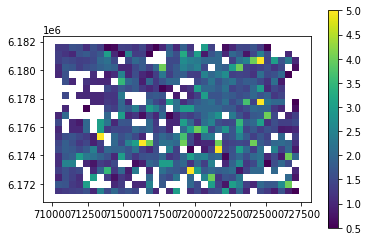

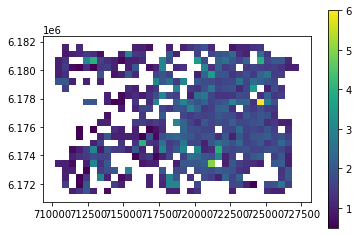

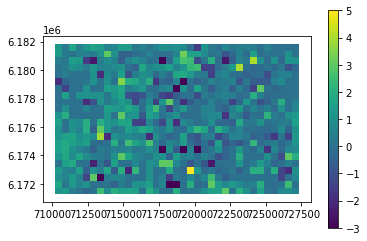

In [17]:
# Per grid cell
results_dict = {}
data = (osm_edges_s_j, osm_nodes_s_j)
[ef.run_grid_analysis(grid_id, data, results_dict, ef.compute_edge_node_ratio) for grid_id in grid_ids];

results_df = pd.DataFrame.from_dict(results_dict, orient='index')
results_df.reset_index(inplace=True)
results_df.rename(columns={'index':'grid_id', 0:'osm_edge_node_ratio'}, inplace=True)

grid = grid.merge(results_df, on='grid_id', how='left')

results_dict = {}
data = (ref_edges_s_j, ref_nodes_s_j)
[ef.run_grid_analysis(grid_id, data, results_dict, ef.compute_edge_node_ratio) for grid_id in grid_ids];

results_df = pd.DataFrame.from_dict(results_dict, orient='index')
results_df.reset_index(inplace=True)
results_df.rename(columns={'index':'grid_id', 0:'ref_edge_node_ratio'}, inplace=True)

grid = grid.merge(results_df, on='grid_id', how='left')

grid['edge_node_ratio_diff'] = grid.osm_edge_node_ratio.fillna(value=0) - grid.ref_edge_node_ratio.fillna(value=0)

# TODO: Format plotting
grid.plot(column='osm_edge_node_ratio', legend=True);
grid.plot(column='ref_edge_node_ratio', legend=True);
grid.plot(column='edge_node_ratio_diff', legend=True);

____________________________

## 4. Network topology

### Why?

### What?

### What does it mean?

### Dangling nodes & under/overshoots

A dangling node in a network is all the start and end nodes - in other words, nodes that do not represent intersections between edges, but indicates where an edge begins or ends.

Most networks will naturally contain a number of dangling nodes. How many does to some extent depend on the digitization method (*see illustration below for how the digitization method determines whether a dangling node wil occur.*)

The presence of dangling nodes are thus in itself not a sign of low data quality, but a high number in an area that is not known for suffering from many dead-ends can indicate digitization errors and problems with edge under- and overshoot (see below or GIS Lounge for an [explanation of under- and overshoots](https://www.gislounge.com/digitizing-errors-in-gis/)).

When two nodes in a simplified network are placed within a distance of a few meters, but do not share a common edge, we often have a case of an edge over/under shoot or another digitizing error.

Based on Barron et al., 2013.

- Not always a problem - the feature might play a role - but overshoots can skew the analysis of network structure
- Undershoots a problem for any routing that only considers cycling infrastructure


<img src='../images/dangling_nodes_illustration.png' height=200 />  <img src='../images/no_dangling_nodes_illustration.png' height=200 />

*Dangling nodes occur where road features end (left), but when separate features are joined at the end (right), there will be no dangling nodes*

<img src='../images/overshoot_illustration.png' height=200 />  <img src='../images/undershoot_illustration.png' height=200 />

*Overshoots refer to situations where a line feature extends too far beyond at intersecting line, rather than ending at the intersection (left).* 
*Undershoots happen when two line features are not properly joined, for example at at intersection (right)*

#### Global measure of dangling nodes

In [ ]:
osm_dangling_nodes = ef.get_dangling_nodes(osm_simplified_edges, osm_simplified_nodes)

fig, ax = plt.subplots(1, figsize=(20,20))

osm_simplified_edges.plot(ax=ax, color='black', linewidth=0.5)
osm_simplified_nodes.plot(ax=ax, color='black', markersize=5)
osm_dangling_nodes.plot(ax=ax, color='red', markersize=20)

cx.add_basemap(
        ax, 
        crs=osm_simplified_edges.crs, 
        source=cx.providers.CartoDB.Voyager
    )


ref_dangling_nodes = ef.get_dangling_nodes(ref_simplified_edges, ref_simplified_nodes)

fig, ax = plt.subplots(1, figsize=(20,20))

ref_simplified_edges.plot(ax=ax, color='black', linewidth=0.5)
ref_simplified_nodes.plot(ax=ax, color='black', markersize=5)
ref_dangling_nodes.plot(ax=ax, color='red', markersize=20)

cx.add_basemap(
        ax, 
        crs=osm_simplified_edges.crs, 
        source=cx.providers.CartoDB.Voyager
    )

results_osm['dangling_node_count'] = len(osm_dangling_nodes)
results_ref['dangling_node_count'] = len(ref_dangling_nodes)

#### Local measures of dangling nodes

In [ ]:
dn_osm_joined = gpd.overlay(osm_dangling_nodes, grid[['geometry','grid_id']], how ='intersection')
df = ef.count_features_in_grid(dn_osm_joined,'osm_dangling_nodes')
grid = grid.merge(df, on='grid_id', how='left')

dn_ref_joined = gpd.overlay(ref_dangling_nodes, grid[['geometry','grid_id']], how ='intersection')
df = ef.count_features_in_grid(dn_ref_joined,'ref_dangling_nodes')
grid = grid.merge(df, on='grid_id', how='left')

grid['osm_dangling_nodes_per_node'] = grid.count_osm_dangling_nodes / grid.count_osm_simplified_nodes
grid['ref_dangling_nodes_per_node'] = grid.count_ref_dangling_nodes / grid.count_ref_simplified_nodes

grid.plot(column='osm_dangling_nodes_per_node',legend=True)
grid.plot(column='ref_dangling_nodes_per_node',legend=True);

#### Overshoots

In [ ]:
osm_overshoots = ef.find_overshoots(osm_dangling_nodes, osm_simplified_edges, 3)
ref_overshoots = ef.find_overshoots(ref_dangling_nodes, ref_simplified_edges, 3)

results_osm['count_overshoots'] = len(osm_overshoots)
results_ref['count_overshoots'] = len(ref_overshoots)

osm_overshoots.plot();
# TODO: Make Folium plot - should be possible to zoom in!

ref_overshoots.plot();
# TODO: Make Folium plot - should be possible to zoom in!

#### Undershoots

In [ ]:
osm_undershoot_dict, osm_undershoot_nodes = ef.find_undershoots(osm_dangling_nodes, osm_simplified_edges, 3,'edge_id')

ref_undershoot_dict, ref_undershoot_nodes = ef.find_undershoots(ref_dangling_nodes, ref_simplified_edges, 3,'edge_id')

results_osm['count_undershoots'] = len(osm_undershoot_nodes)
results_ref['count_undershoots'] = len(ref_undershoot_nodes)

osm_undershoot_nodes.plot();
ref_undershoot_nodes.plot();

# TODO: make folium plt

__________________

## 5. Connected Components

### What?

### How?

### What could it mean?

### Number of connected components

The OSM network in the study area consists of 340 unconnected components.


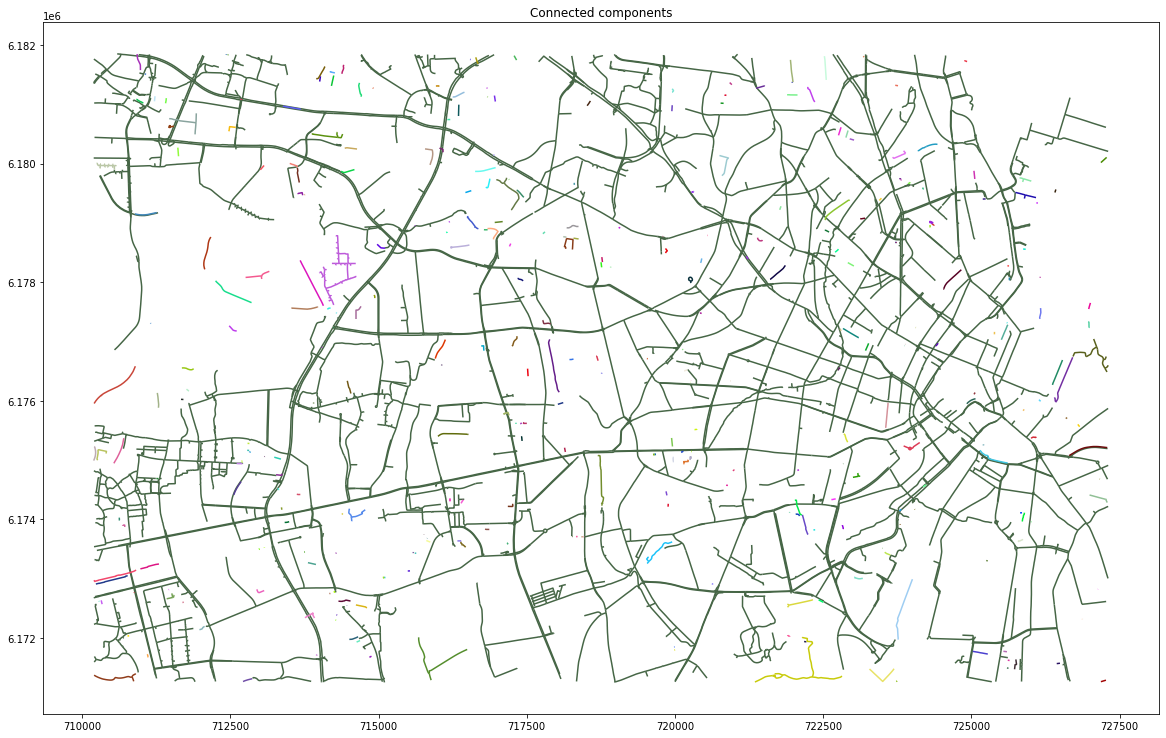

The reference network in the study area consists of 195 unconnected components.


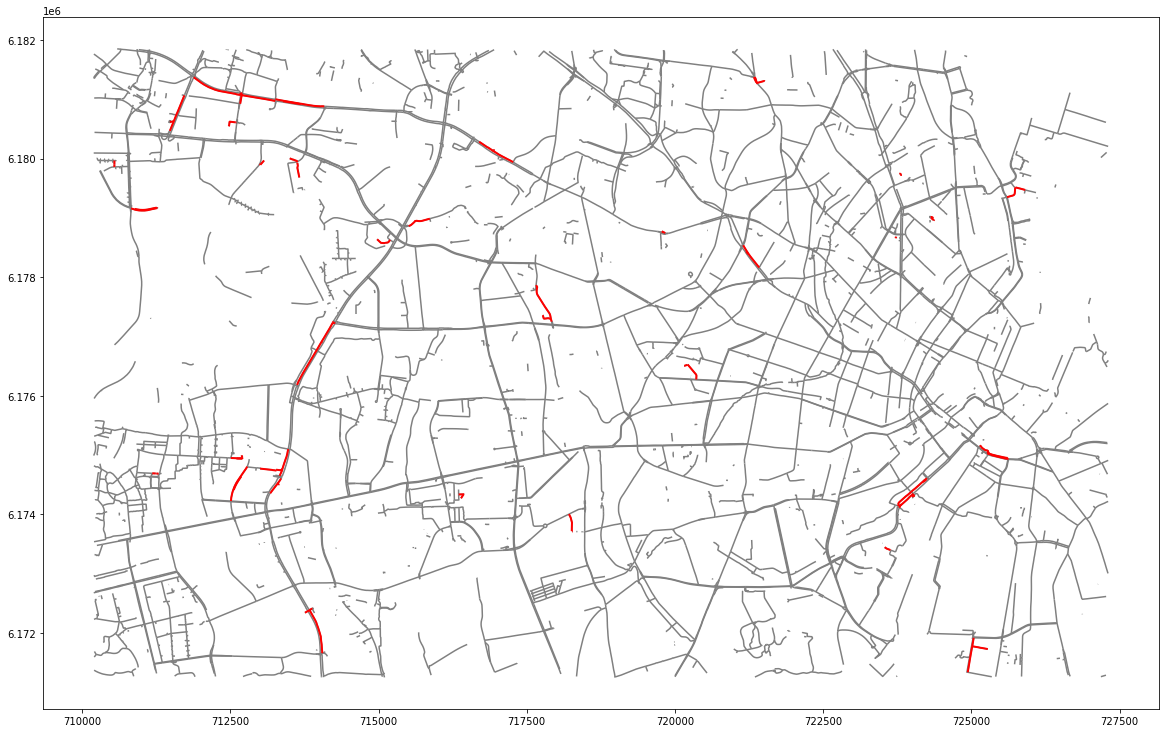

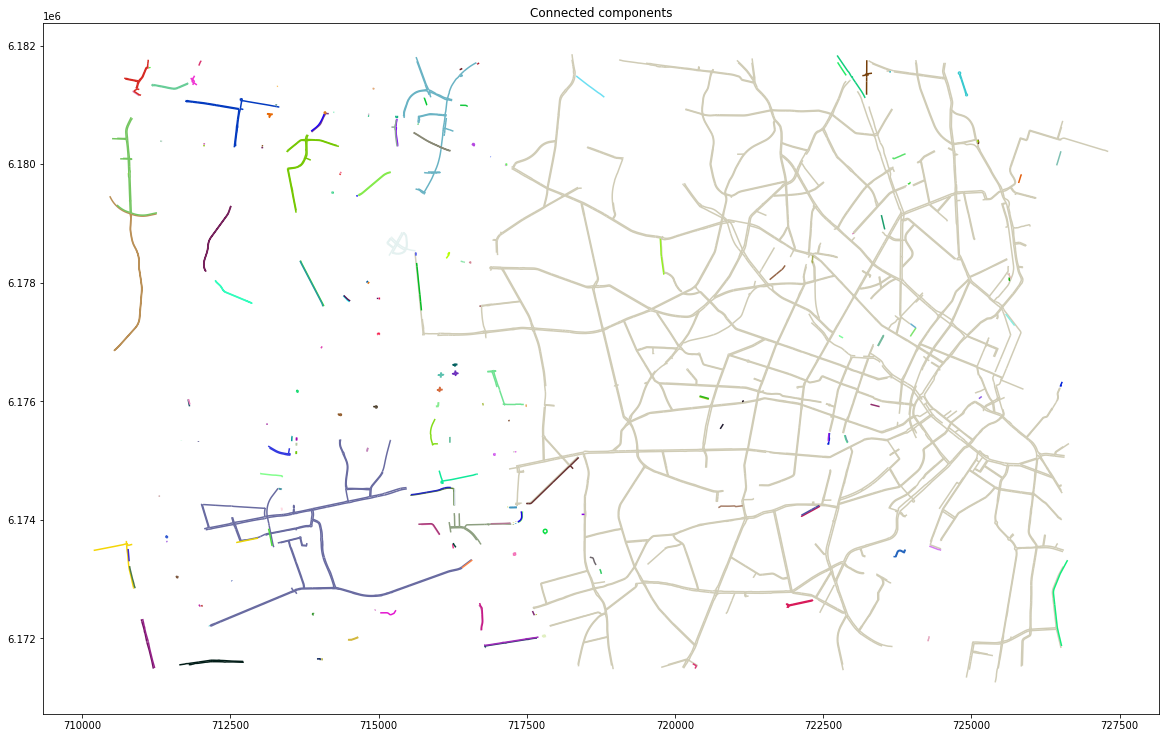

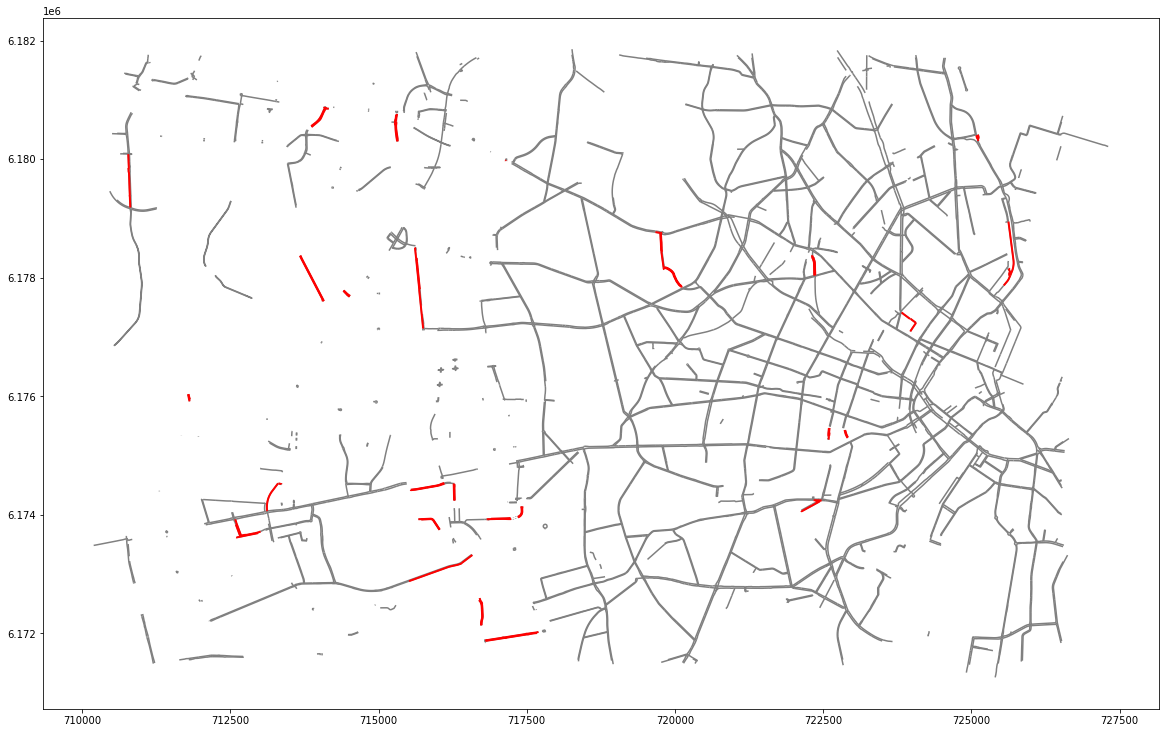

In [18]:
# TODO: Compare plots of unconnected issues!

osm_components = ef.return_components(osm_simplified_graph)
print(f'The OSM network in the study area consists of {len(osm_components)} unconnected components.')

components_plot = ef.plot_components(osm_components)

osm_comp_issues = ef.find_adjacent_components(components=osm_components, buffer_dist=10, crs=study_crs)

fig, ax = plt.subplots(figsize=(20,20))

osm_simplified_edges.plot(ax=ax, color='grey');
osm_comp_issues.plot(ax=ax, color='red', linewidth=2);

# TODO: Fix plot - plot with unconnected components as well

ref_components = ef.return_components(ref_simplified_graph)
print(f'The reference network in the study area consists of {len(ref_components)} unconnected components.')

components_plot = ef.plot_components(ref_components)

ref_comp_issues = ef.find_adjacent_components(components=ref_components, buffer_dist=10, crs=study_crs)

fig, ax = plt.subplots(figsize=(20,20))

ref_simplified_edges.plot(ax=ax, color='grey');
ref_comp_issues.plot(ax=ax, color='red', linewidth=2);

# TODO: Fix plot - plot with unconnected ref_components as well

### Distribution of network length per component

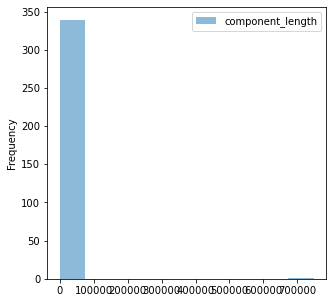

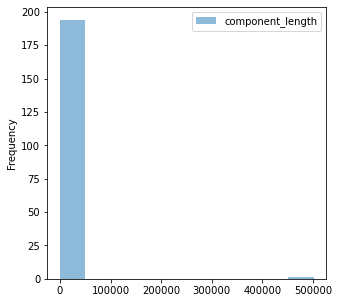

In [19]:
osm_components_df = ef.component_lengths(osm_components)
ax = osm_components_df.plot.hist(column='component_length', bins=10, alpha=0.5, figsize = (5,5))

ref_components_df = ef.component_lengths(ref_components)
ax = ref_components_df.plot.hist(column='component_length', bins=10, alpha=0.5, figsize = (5,5))

### Largest connected component's share of total network length

In [20]:
osm_largest_cc = max(osm_components, key=len)

osm_largest_cc_length = 0

for (u, v, l) in osm_largest_cc.edges(data='length'):

        osm_largest_cc_length += l

osm_largest_cc_pct = osm_largest_cc_length / osm_components_df['component_length'].sum() * 100

print(f'The largest connected component in the OSM network contains {osm_largest_cc_pct:.2f} % of the network length.')

ref_largest_cc = max(ref_components, key=len)

ref_largest_cc_length = 0

for (u, v, l) in ref_largest_cc.edges(data='length'):

        ref_largest_cc_length += l

ref_largest_cc_pct = ref_largest_cc_length / ref_components_df['component_length'].sum() * 100

print(f'The largest connected component in the reference network contains {ref_largest_cc_pct:.2f} % of the network length.')

# TODO Add plot comparing the two. And maybe plot just the largest ones?

The largest connected component in the OSM network contains 92.70 % of the network length.
The largest connected component in the reference network contains 80.40 % of the network length.


### Ratio of edges to connected components

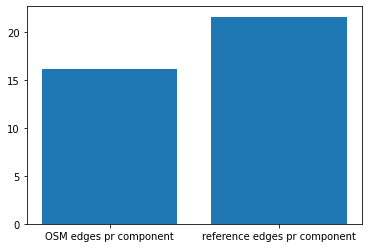

In [21]:
osm_edge_component_ratio =  len(osm_simplified_edges) / len(osm_components)
ref_edge_component_ratio = len(ref_simplified_edges) / len(ref_components)

values = [osm_edge_component_ratio, ref_edge_component_ratio]
labels = ['OSM edges pr component','reference edges pr component']

# TODO format plot
plt.bar(range(len(values)), values, tick_label=labels);

Assign component id to grid:

In [22]:
grid = ef.assign_component_id_to_grid(osm_simplified_edges, osm_edges_s_j, osm_components, grid, prefix='osm', edge_id_col='edge_id')

grid = ef.assign_component_id_to_grid(ref_simplified_edges, ref_edges_s_j, ref_components, grid, prefix='ref', edge_id_col='edge_id')

fill_na_dict = {'component_ids_osm': '','component_ids_ref': ''}
grid.fillna(value=fill_na_dict,inplace=True)

### Grid cells with more than one component:

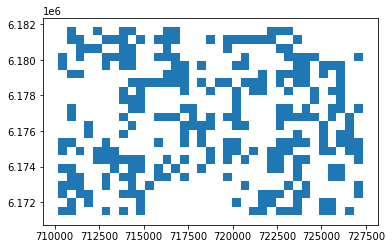

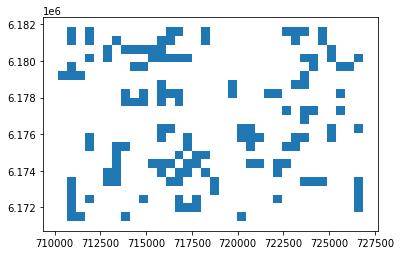

In [23]:
# Cells with more than one component
grid.loc[grid['component_ids_osm'].map(len) > 1].plot();

grid.loc[grid['component_ids_ref'].map(len) > 1].plot();

### Component connectivity

Visualising differences between how many cells can be reached from each cell.
Positive values in the plot means that more cells can be reached from this particular cell using the OSM data, while negative values indicate a higher connectivity using the reference data set.

This is a crude measure for network connectivity, but has the benefit of being computationally cheap and able to highlight stark differences in network connectivity.

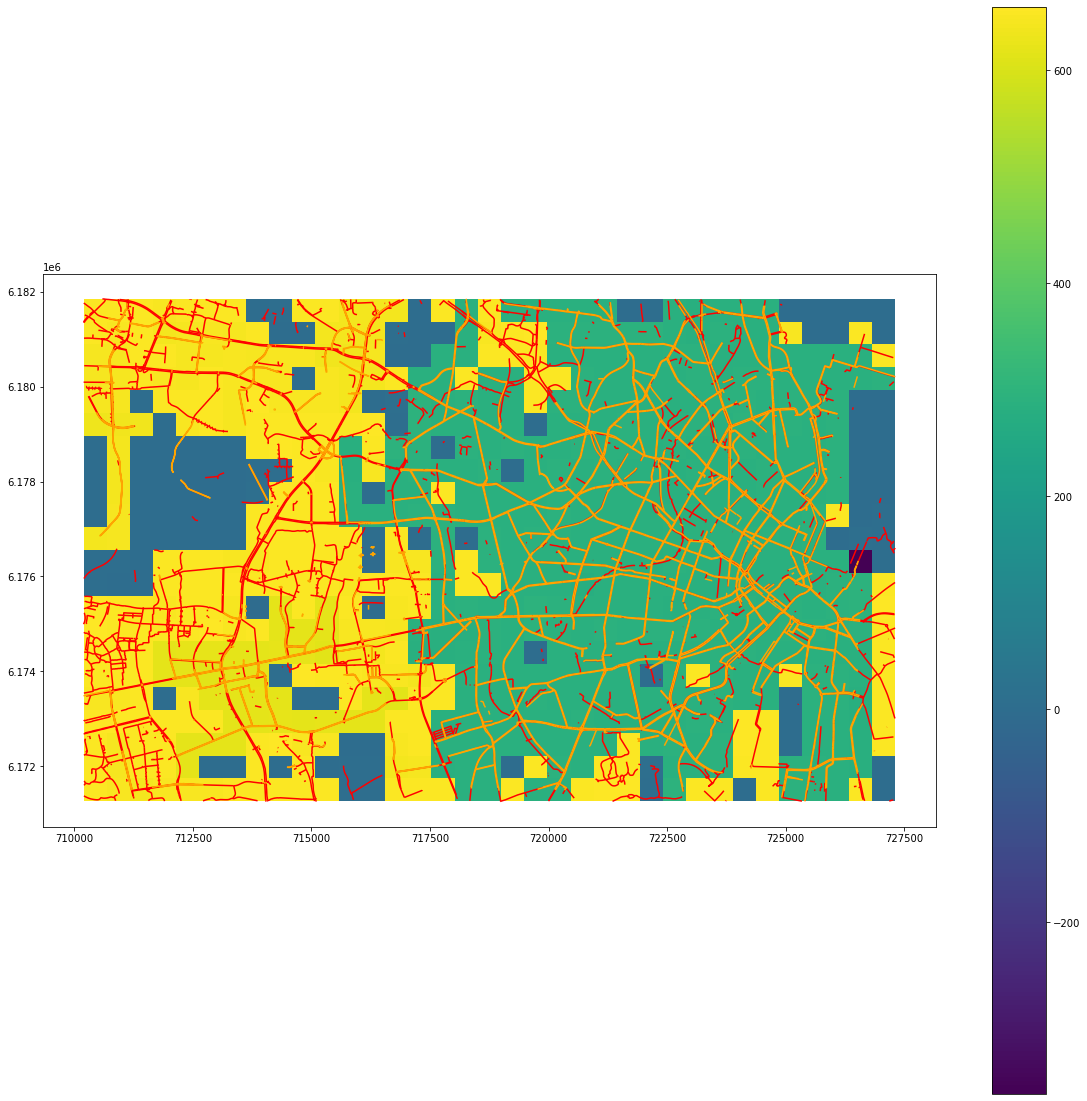

In [24]:
osm_components_cell_count = ef.count_component_cell_reach(osm_components_df, grid, 'component_ids_osm')
grid['cells_reached_osm'] = grid['component_ids_osm'].apply(lambda x: ef.count_cells_reached(x, osm_components_cell_count) if x != '' else 0)

ref_components_cell_count = ef.count_component_cell_reach(ref_components_df, grid, 'component_ids_ref')
grid['cells_reached_ref'] = grid['component_ids_ref'].apply(lambda x: ef.count_cells_reached(x, ref_components_cell_count) if x != '' else 0)

grid['cell_reach_diff'] = grid['cells_reached_osm'] - grid['cells_reached_ref']

# TODO: Plot
fig, ax = plt.subplots(figsize=(20,20))

grid.plot(ax=ax, column='cell_reach_diff', legend=True)
osm_simplified_edges.plot(ax=ax, color='red')
ref_simplified_edges.plot(ax=ax, color='orange');

In [32]:
# Saving results of component analysis

results_osm['component_count'] = len(osm_components)
results_osm['largest_cc_pct_size'] = osm_largest_cc_pct
results_osm['largest_cc_length_km'] = osm_largest_cc_length / 1000
results_osm['component_gaps'] = len(osm_comp_issues)
results_osm['edge_component_ratio'] = osm_edge_component_ratio

results_ref['component_count'] = len(ref_components)
results_ref['largest_cc_pct_size'] = ref_largest_cc_pct
results_ref['largest_cc_length_km'] = ref_largest_cc_length / 1000
results_ref['component_gaps'] = len(ref_comp_issues)
results_ref['edge_component_ratio'] = ref_edge_component_ratio


________________________

## 6. Save results

In [33]:
all_results['osm_results'] = results_osm
all_results['ref_results'] = results_ref

with open(f'../results/extrinsic_analysis_{study_area}.json', 'w') as outfile:
    json.dump(all_results, outfile)


with open(f'../results/grid_results_extrinsic_{study_area}.pickle', 'wb') as f:
    pickle.dump(grid, f)

__________________

For a summary of core metrics, run the notebook [summary of extrinsic analysis](./summary_extrinsinc_analysis.ipynb).